# MSE 211 MDP Project

We can do the project here

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import random
from enum import Enum
from abc import ABC, abstractmethod, abstractproperty
import copy
import itertools
import time
# States
# Actions

# States 
# Actions
# Rewards
class UpdateRule(Enum):
    DURING_SWEEP = "DURING SWEEP"
    AFTER_SWEEP = "AFTER SWEEP"

class ValueIterator(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get_states(self, states, **kwargs):
        pass

    @abstractproperty
    def update_rule(self):
        pass

    @property
    def name(self):
        return type(self).__name__

    
    def iterate(self, mdp, gamma, V_0):
        V = V_0
        V_copy = None if self.update_rule != UpdateRule.AFTER_SWEEP else copy.deepcopy(V_0)
        
        # If update during sweep, use the same v
        # If not updating during sweep, store and update later
        
        for state in self.get_states(mdp.states):
            costs = []
            for action in mdp.actions(state):
                # Immediate reward
                state_action_cost = mdp.reward(state, action)
                for (next_state, p) in mdp.transition(state, action):
                    # Values based on next states
                    state_action_cost += gamma * p * V[next_state]

                costs.append(state_action_cost)
                

            new_cost = max(costs, default=0)
            
            if self.update_rule == UpdateRule.DURING_SWEEP:
                V[state] = new_cost
                
            elif self.update_rule == UpdateRule.AFTER_SWEEP:
                V_copy[state] = new_cost

        # Return values at the end
        if self.update_rule == UpdateRule.AFTER_SWEEP:
            return V_copy
        elif self.update_rule == UpdateRule.DURING_SWEEP:
            return V



class ClassicVI(ValueIterator):
    def get_states(self, states, **kwargs):
        return states

    @property
    def update_rule(self):
        return UpdateRule.AFTER_SWEEP

class RandomVI(ValueIterator):
    def __init__(self, k):
        super().__init__()
        self.k = k
    
    def get_states(self, states, **kwargs):
        return random.sample(states, self.k)

    @property
    def update_rule(self):
        return UpdateRule.AFTER_SWEEP

    @property
    def name(self):
        return "{} (k={})".format(type(self).__name__, self.k)

class CyclicVI(ValueIterator):
    def get_states(self, states, **kwargs):
        return states

    @property
    def update_rule(self):
        return UpdateRule.DURING_SWEEP

class RandomCyclicVI(ValueIterator):
    def get_states(self, states, **kwargs):
        return random.sample(states, k=len(states))

    @property
    def update_rule(self):
        return UpdateRule.DURING_SWEEP


In [2]:
import itertools
class MDP(ABC):

    @abstractmethod
    def actions(self,state):
        pass

    @abstractmethod
    def transition(self,state, action):
        pass

    @abstractmethod
    def reward(self, state, action):
        pass

    @abstractmethod
    def prob(self, state, action):
        pass

    


In [3]:
class Solver:
    def __init__(self, iterator, mdp, gamma):
        self.iterator = iterator
        self.mdp = mdp
        self.gamma = gamma
        self.solution = None
        self.deltas = None
        self.time_each_step = None

    def solve(self, steps=None, threshold=None):
        assert (steps is not None) != (threshold is not None), "either steps or threshold should be defined"
        V = { state: 0 for state in self.mdp.states}
        deltas = []
        time_each_step = []

        step = 0
        while ((threshold is not None) and (len(deltas) == 0 or deltas[-1] > threshold)) or (steps is not None and step <= steps):
            t_0 = time.time()
            
            V_0 = copy.deepcopy(V)
            V_new = self.iterator.iterate(self.mdp, self.gamma, V)
            
            # Calculate the delta by seeing the biggest change between the two versions
            delta = max([abs(V_new[state] - V_0[state]) for state in V])
            deltas.append(delta)

            V = V_new

            time_difference = time.time() - t_0
            time_each_step.append(time_difference)

            step += 1

            

        self.solution = V
        self.deltas = deltas
        self.time_each_step = time_each_step


    def plot_delta(self):
        deltas = self.deltas
        if deltas is not None:
            label = self.iterator.name
            plt.plot(deltas, label=label, alpha=0.9)
            plt.xlabel("Iteration")
            plt.ylabel("Delta")


    def plot_time(self):
        time_steps = self.time_each_step
        if time_steps is not None:
            label = self.iterator.name
            plt.plot(time_steps, label=label)
            plt.xlabel("Time Step")
            plt.ylabel("Time (s)")


In [71]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

def replace_char(s, char, index):
    return s[:index] + char + s[index + 1:]
    

class TicTacToe(MDP):
    class StateCondition(Enum):
        CONTINUE = "Continue"
        WIN = "Player win"
        LOSE = "Opponent win"
        TIE = "Tie"
        INVALID = "Invalid"
    

    def __init__(self, player="X"):
        self.states = self.generate_states(for_player=player)
        self._actions = {}
        self.player = player
        self.opponent = "O" if player == "X" else "O"

    
    def actions(self, state):
        action_set = []
        # If we're in a goal state, there are no more actions to do
        if self.condition(state, "actions") != TicTacToe.StateCondition.CONTINUE:
            return [state]
        
        # Actions are filling in any of the empty spaces with a "pawn"
        blank_positions = find_indices(list(state), "-")

        player_count = state.count(self.player)
        opponent_count = state.count(self.opponent)

        # The player goes first, so if the player has more pieces on the board, then
        # It's the opponent's turn to place something
        
        pawn = self.opponent if player_count > opponent_count else self.player
            
        for pos in blank_positions:
            action = replace_char(state, pawn, pos)
            action_set.append(action)
            
        
        return action_set

    
    def transition(self, state, action):
        # Being in the win condition just returns you to the same
        # state. same with a tie, or end of game generally
        condition = self.condition(state, "transition")
        if (condition != TicTacToe.StateCondition.CONTINUE):
            return [(state, 1.0)]
        
        
        # We can place more pieces on the board
        # The action is the board when the spot is placed
        # With the given action, the next state is placing the opponent
        blank_positions = find_indices(list(action), "-")
        next_states = []

        # Fill in each available space one at a time
        for pos in blank_positions:
            next_state = replace_char(action, self.opponent, pos)
            next_states.append(next_state)
        # print("State:", state, "Next States", next_states)
        # Equal probability for each state to happen
        # e.g. this action has an equal probability to transition to any state
        return [(next_state, 1.0 / len(next_states)) for next_state in next_states]

    
    def reward(self, state, action):
        # According to the lecture notes, a win is
        # Noted by a reward of -1
        # Losing is noted by 1
        # Ties are 0
        #print("Value of state:", state)
        condition = self.condition(state, "reward")
        
        if condition == TicTacToe.StateCondition.WIN:
            #print("Win Condition: {}".format(state))
            return 1
        elif condition == TicTacToe.StateCondition.LOSE:
            return -1
        else:
            #print("Rewards")
            return 0

    
    def prob(self, state, action):
        actions = self.actions(state)
        return { action: 1 / len(actions) for action in actions }

    def generate_states(self, for_player):
        # Fill out the grid for the board
        # Prune unreachable variants
        # States here are only for the player, not opponent

        def valid_board(board):
            # X and O count are at most 1 different from each other
            x_count = board.count("X")
            o_count = board.count("O")

            one_off_count = abs(x_count - o_count) <= 1
            empty_board = board == "-" * 9
            majority_player_board = x_count >= o_count if for_player == "X" else o_count >= x_count
            
            return  (one_off_count and majority_player_board) or empty_board
        
        all_boards = list(map(lambda board: "".join(board), itertools.product(["X", "O", "-"], repeat=9)))
        #boards = list(filter(valid_board, all_boards))
        return all_boards


    def winner(self, board, player):
        """
        Determine the winner for a game of Tic Tac Toe
        """
        player_match = player * 3
        # Column matches
        for i in range(3):
            if board[i::3] == player_match:
                return True
        
        # Row matches
        for i in range(0,7,3):
            if board[i: i + 3] == player_match:
                return True
    
        # Diagonals
        left_diagonal = board[0] + board[4] + board[8]
        right_diagonal = board[2] + board[4] + board[6]
    
        return left_diagonal == player_match or right_diagonal == player_match

    def tie(self, board):
        """
        Determine if a tie has occured
        """
        # Tie happens when there are 8 elements (4 of each) and no winner
        x_count = board.count("X")
        o_count = board.count("O")

        four_each = x_count == 4 and o_count == 4
        # No win when both the player and opponent have not won
        no_win = not (self.winner(board, self.player) or self.winner(board, self.opponent))

        return four_each and no_win


    def condition(self, board, func):
        # if func == "actions":
        #     print("From", func)
        #     print(self.winner(board, self.player))
        #print(TicTacToe.StateCondition.WIN == TicTacToe.StateCondition.WIN)
        
        if self.winner(board, self.player):
            # print("Returning", TicTacToe.StateCondition.WIN)
            return TicTacToe.StateCondition.WIN
        elif self.winner(board, self.opponent):
            return TicTacToe.StateCondition.LOSE
        elif self.tie(board):
            return TicTacToe.StateCondition.TIE
        else:
            return TicTacToe.StateCondition.CONTINUE

        
            




class Board:
    def __init__(self, board=None):
        if board is not None:
            # Parse board
            rows = board.split("\n")
            self.board = [list(row) for row in rows]
        else:
            self.board = [["-"] * 3 for i in range(3)]


    def valid_board(self):
        pass
    
    def __str__(self):
        rows = ["".join(row) for row in self.board]
        return "\n".join(rows)


    # We place a X, O, or - at a specific position
    # Then we get the valid boards from placing that item there (recurse)

    # If the board we get is invalid, we return nothing
    # If the board we get is valid, we add it to the list of valid boards,
    # Then recurse

    # OR, we generate all the possible versions of the board.
    # Then, we filter out all the boards that are invalid 




In [77]:
model = TicTacToe()
solver = Solver(ClassicVI(), model, 0.9)
solver.solve(steps=10)

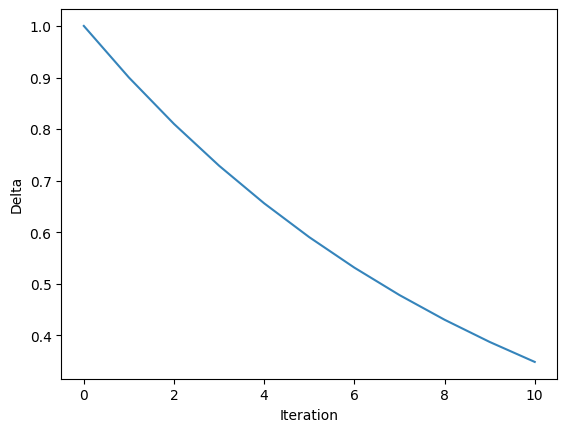

In [78]:
solver.plot_delta()

In [109]:
# Look only at the starting states, which are the ones where there is only
# one X
model = TicTacToe()
N = len(model.states)

iterators = [RandomVI(k=int(k)) for k in [N * 0.1, N * 0.5, N * 0.75]] + [ClassicVI(), CyclicVI(), RandomCyclicVI()] 
solvers = []

for iterator in iterators:
    solver = Solver(iterator, model, 0.9)
    solver.solve(steps=20)
    solvers.append(solver)



In [132]:
def display_start_state_board(ax, solver):

    name = solver.iterator.name
    solution = solver.solution
    solution_keys = list(solution.keys())
    
    def start_state(board):
        x_count = board.count("X")
        o_count = board.count("O")
        return x_count == 1 and o_count == 0
    
    # Get states for initial boards
    initial_boards = list(filter(start_state, solution_keys))
    
    initial_board_data = np.array([solution[board] for board in initial_boards]).reshape(3,3)
    
    cbarlabel="State Value"
    im = ax.imshow(initial_board_data, cmap="summer")
    
    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, "{:.3f}".format(initial_board_data[i, j]),
                           ha="center", va="center", color="black")
    
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_title(name)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

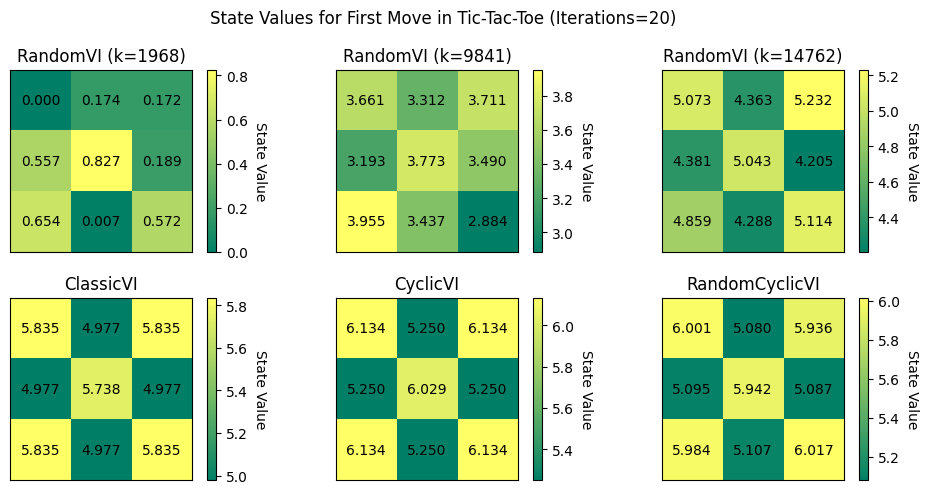

In [135]:
fig, axs = plt.subplots(2,3, figsize=(10,5))
for i, solver in enumerate(solvers):
    ax = axs.flatten()[i]
    display_start_state_board(ax, solver)

fig.suptitle("State Values for First Move in Tic-Tac-Toe (Iterations=20)")
plt.tight_layout()
plt.savefig("figs/tictactoe.png")

In [12]:
boards[-1]

'--------O'

In [13]:
list(boards)

['XXXXXOOOO',
 'XXXXOXOOO',
 'XXXXOOXOO',
 'XXXXOOOXO',
 'XXXXOOOOX',
 'XXXXOOOOO',
 'XXXXOOOO-',
 'XXXXOOO-O',
 'XXXXOOO--',
 'XXXXOO-OO',
 'XXXXOO-O-',
 'XXXXOO--O',
 'XXXXO-OOO',
 'XXXXO-OO-',
 'XXXXO-O-O',
 'XXXXO--OO',
 'XXXX-OOOO',
 'XXXX-OOO-',
 'XXXX-OO-O',
 'XXXX-O-OO',
 'XXXX--OOO',
 'XXXOXXOOO',
 'XXXOXOXOO',
 'XXXOXOOXO',
 'XXXOXOOOX',
 'XXXOXOOOO',
 'XXXOXOOO-',
 'XXXOXOO-O',
 'XXXOXOO--',
 'XXXOXO-OO',
 'XXXOXO-O-',
 'XXXOXO--O',
 'XXXOX-OOO',
 'XXXOX-OO-',
 'XXXOX-O-O',
 'XXXOX--OO',
 'XXXOOXXOO',
 'XXXOOXOXO',
 'XXXOOXOOX',
 'XXXOOXOOO',
 'XXXOOXOO-',
 'XXXOOXO-O',
 'XXXOOXO--',
 'XXXOOX-OO',
 'XXXOOX-O-',
 'XXXOOX--O',
 'XXXOOOXXO',
 'XXXOOOXOX',
 'XXXOOOXOO',
 'XXXOOOXO-',
 'XXXOOOX-O',
 'XXXOOOX--',
 'XXXOOOOXX',
 'XXXOOOOXO',
 'XXXOOOOX-',
 'XXXOOOOOX',
 'XXXOOOO-X',
 'XXXOOOO--',
 'XXXOOO-XO',
 'XXXOOO-X-',
 'XXXOOO-OX',
 'XXXOOO-O-',
 'XXXOOO--X',
 'XXXOOO--O',
 'XXXOOO---',
 'XXXOO-XOO',
 'XXXOO-XO-',
 'XXXOO-X-O',
 'XXXOO-OXO',
 'XXXOO-OX-',
 'XXXOO-OOX',
 'XXXO

In [14]:
original = "".join(map(str, range(1,10)))

print(original)
print(original[0:3])

123456789
123


In [15]:
def winner(board, player):
    player_match = player * 3
    # Column matches
    for i in range(3):
        if board[i::3] == player_match:
            return True
    
    # Row matches
    for i in range(0,7,3):
        if board[i: i+3] == player_match:
            return True

    # Diagonals
    left_diagonal = board[0] + board[4] + board[8]
    right_diagonal = board[2] + board[4] + board[6]

    return left_diagonal == player_match or right_diagonal == player_match
    

In [16]:
t = TicTacToe()
t.winner("XOXXO-X--", "X")

True

In [17]:
original[6:9]

'789'

In [18]:
print(list(range(0,7,3)))

[0, 3, 6]
